# UFC Case Study Notebook

## Importing libraries

In [1]:
#from collections import Counter
from datetime import datetime
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import kagglehub

## Util functions

In [2]:
def human_readable_date(date):
    # usage example d = human_readable_date(datetime.today())
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")  # ou "%d/%m/%Y" se for BR

    day = date.day
    year = date.year
    month = date.strftime("%B")

    # Sufixos: st, nd, rd, th
    if 11 <= day <= 13:
        suffix = "th"
    else:
        last_digit = day % 10
        suffix = {1: "st", 2: "nd", 3: "rd"}.get(last_digit, "th")

    return f"{month} {day}{suffix}, {year}"

def human_readable_duration(seconds: int) -> str:
    if seconds < 0:
        raise ValueError("Duration cannot be negative")

    minutes, sec = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)

    parts = []
    if hours:
        parts.append(f"{hours} hour" + ("s" if hours != 1 else ""))
    if minutes:
        parts.append(f"{minutes} minute" + ("s" if minutes != 1 else ""))
    if not parts:
        parts.append("less than a minute")

    return " and ".join(parts)

## Raw data fetch

In [3]:
path = kagglehub.dataset_download("neelagiriaditya/ufc-datasets-1994-2025")
print("Path to dataset files:", path)

data_folder = "/UFC DATASETS/"

raw_event_details = pd.read_csv(path + data_folder + "event_details.csv", parse_dates=["date"])
raw_figther_details = pd.read_csv(path + data_folder + "fighter_details.csv", parse_dates=["dob"])
raw_fight_details = pd.read_csv(path + data_folder + "fight_details.csv")
raw_ufc_details = pd.read_csv(path + data_folder + "UFC.csv", parse_dates=["date", "r_dob", "b_dob"])

Path to dataset files: /Users/joaogouveiaml/.cache/kagglehub/datasets/neelagiriaditya/ufc-datasets-1994-2025/versions/1


## Data basic exploration

### Event details exploration

In [4]:
raw_event_details.head()

,event_id,fight_id,date,location,winner,winner_id
0,400c7b43c86d27d3,03bc32bdb5a33496,2025-06-21,"Baku, Azerbaijan",Khalil Rountree Jr.,749f572d1d3161fb
1,400c7b43c86d27d3,a1afc16e21d1a807,2025-06-21,"Baku, Azerbaijan",Rafael Fiziev,c814b4c899793af6
2,400c7b43c86d27d3,8e5744c664fec3e9,2025-06-21,"Baku, Azerbaijan",Curtis Blaydes,fa6796c55d6c5440
3,400c7b43c86d27d3,36ec204f47e4d613,2025-06-21,"Baku, Azerbaijan",Myktybek Orolbai,bf2c8e01b07d3eb1
4,400c7b43c86d27d3,7513a00037094075,2025-06-21,"Baku, Azerbaijan",Nazim Sadykhov,ff62013d2fce6d13


In [5]:
raw_event_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8250 entries, 0 to 8249
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   event_id   8250 non-null   object        
 1   fight_id   8250 non-null   object        
 2   date       8250 non-null   datetime64[ns]
 3   location   8250 non-null   object        
 4   winner     8104 non-null   object        
 5   winner_id  8104 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 386.8+ KB


### Fighter details exploration

In [6]:
raw_figther_details.head()

,id,name,nick_name,wins,losses,draws,height,weight,reach,stance,dob,splm,str_acc,sapm,str_def,td_avg,td_avg_acc,td_def,sub_avg
0,74fefd43f073cd2f,Joe Pardo,NaN,4,6,0,185.42,95.25,NaN,Southpaw,NaT,0.00,0,0.00,0,0.00,0,0,0.0
1,8c1ca54b5089d199,Maheshate,NaN,10,4,0,182.88,70.31,180.34,Orthodox,1999-12-01,3.86,29,5.64,53,0.00,0,45,0.0
2,4234f0097c83fa62,Sijara Eubanks,SarJ,8,7,0,162.56,56.70,170.18,Orthodox,1985-04-27,4.30,43,3.43,57,1.90,44,66,0.3
3,1291edf2d566a71a,Julio Arce,NaN,19,6,0,170.18,65.77,177.80,Southpaw,1989-10-27,4.36,36,3.05,68,0.46,28,96,0.3
4,7a47e068f8017019,Val Woodburn,The Animal,7,2,0,172.72,77.11,187.96,Orthodox,1993-08-10,1.60,35,4.93,36,1.92,100,50,0.0


In [7]:
raw_figther_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2598 entries, 0 to 2597
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          2598 non-null   object        
 1   name        2598 non-null   object        
 2   nick_name   1682 non-null   object        
 3   wins        2598 non-null   int64         
 4   losses      2598 non-null   int64         
 5   draws       2598 non-null   int64         
 6   height      2577 non-null   float64       
 7   weight      2580 non-null   float64       
 8   reach       1943 non-null   float64       
 9   stance      2521 non-null   object        
 10  dob         2442 non-null   datetime64[ns]
 11  splm        2598 non-null   float64       
 12  str_acc     2598 non-null   int64         
 13  sapm        2598 non-null   float64       
 14  str_def     2598 non-null   int64         
 15  td_avg      2598 non-null   float64       
 16  td_avg_acc  2598 non-nul

### Fight details exploration

In [8]:
raw_fight_details.head()

,event_name,event_id,fight_id,r_name,r_id,b_name,b_id,division,title_fight,method,...,b_clinch_acc,b_ground_landed,b_ground_atmpted,b_ground_acc,b_landed_head_per,b_landed_body_per,b_landed_leg_per,b_landed_dist_per,b_landed_clinch_per,b_landed_ground_per
0,UFC Fight Night: Hill vs. Rountree Jr.,400c7b43c86d27d3,36ec204f47e4d613,Tofiq Musayev,ae81a3ac7b260411,Myktybek Orolbai,bf2c8e01b07d3eb1,catch weight,0,Submission,...,NaN,1.0,3.0,33.0,100.0,0.0,0.0,50.0,0.0,50.0
1,UFC Fight Night: Hill vs. Rountree Jr.,400c7b43c86d27d3,a1afc16e21d1a807,Rafael Fiziev,c814b4c899793af6,Ignacio Bahamondes,e4a47b07044ddd72,lightweight,0,Decision - Unanimous,...,38.0,0.0,0.0,NaN,46.0,26.0,28.0,94.0,6.0,0.0
2,UFC Fight Night: Hill vs. Rountree Jr.,400c7b43c86d27d3,7513a00037094075,Nazim Sadykhov,ff62013d2fce6d13,Nikolas Motta,37f560436d745c18,lightweight,0,KO/TKO,...,55.0,0.0,0.0,NaN,69.0,24.0,6.0,81.0,18.0,0.0
3,UFC Fight Night: Hill vs. Rountree Jr.,400c7b43c86d27d3,e512b80bbaea36c2,Seokhyeon Ko,4a07b1988477502c,Oban Elliott,6b56e94a59b7b134,welterweight,0,Decision - Unanimous,...,100.0,0.0,0.0,NaN,20.0,60.0,20.0,90.0,10.0,0.0
4,UFC Fight Night: Hill vs. Rountree Jr.,400c7b43c86d27d3,03bc32bdb5a33496,Jamahal Hill,5444c5a201d3ee5a,Khalil Rountree Jr.,749f572d1d3161fb,light heavyweight,0,Decision - Unanimous,...,NaN,0.0,0.0,NaN,29.0,41.0,29.0,100.0,0.0,0.0


In [9]:
raw_fight_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8250 entries, 0 to 8249
Data columns (total 86 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   event_name           8250 non-null   object 
 1   event_id             8250 non-null   object 
 2   fight_id             8250 non-null   object 
 3   r_name               8250 non-null   object 
 4   r_id                 8250 non-null   object 
 5   b_name               8250 non-null   object 
 6   b_id                 8250 non-null   object 
 7   division             8250 non-null   object 
 8   title_fight          8250 non-null   int64  
 9   method               8250 non-null   object 
 10  finish_round         8250 non-null   int64  
 11  match_time_sec       8250 non-null   int64  
 12  total_rounds         8219 non-null   float64
 13  referee              8224 non-null   object 
 14  r_kd                 8229 non-null   float64
 15  r_sig_str_landed     8229 non-null   f

# Fight details initial cleaning

> Only weight categories with short names (up to two words) and divisions with no numbers in the name were considered, as long names suggest personalized, inconsistent, or poorly categorized divisions in the raw data. Also Superfight Championship and Open Weight were removed because they were disputed only in, respectively 2 and 4 years

In [10]:
filtered_raw_fight_details = raw_fight_details[
    (raw_fight_details["division"].str.split().str.len() <= 2) &
    (~raw_fight_details["division"].str.contains(r'\d', regex=True)) & 
    (~raw_fight_details["division"].str.contains(r'open weight|superfight championship', regex=True))
]

# 1. Description Reports

## Historical overview of the UFC

### Events by year

In [11]:
# fights_by_year = Counter(raw_event_details["date"].map(lambda d: d.year)) my approach, more python way
# One problem with my approach is that I'll have to make a bunch of conversions in order to plot the data
events_by_year = raw_event_details["date"].dt.year.value_counts().sort_index() # LLM approach suggestion, more pandas way

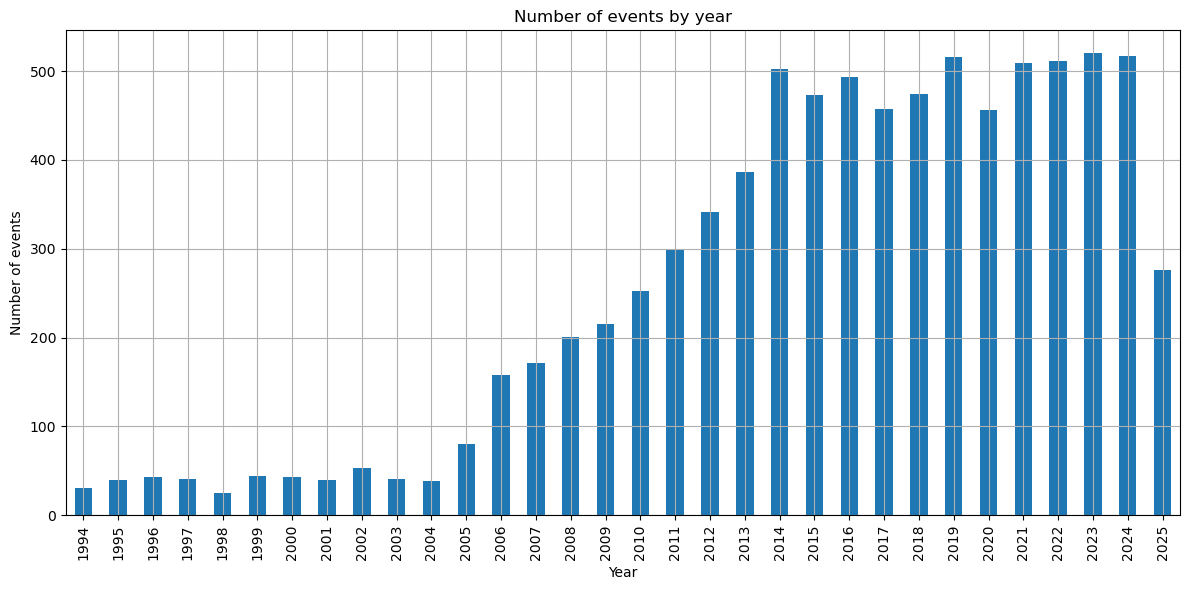

In [12]:
events_by_year.plot(kind="bar", figsize=(12, 6), title="Number of events by year")
plt.xlabel("Year")
plt.ylabel("Number of events")
plt.grid(True)
plt.tight_layout()
plt.show()

> We can see from the chart that the number of events in the year increased significantly from 2005 onwards

### Top 5 Cities and Countries with more events

In [13]:
event_location = raw_event_details["location"].copy()

split_location = event_location.str.split(',', expand=True).apply(lambda col: col.str.strip())

# Creating new data frame
event_location_df = pd.DataFrame()
event_location_df["city"] = split_location[0]
event_location_df["country"] = split_location.apply(
    lambda row: row.iloc[-2] if pd.isna(row.iloc[-1]) else row.iloc[-1],
    axis=1
)

In [14]:
cities_num_of_events = event_location_df["city"].value_counts().sort_values(ascending=False)
cities_num_of_events.head(5)

city
Las Vegas         2787
Abu Dhabi          240
London             183
Rio de Janeiro     147
Newark             127
Name: count, dtype: int64

In [15]:
cities_num_of_events = event_location_df["country"].value_counts().sort_values(ascending=False)
cities_num_of_events.head(5)

country
USA                     5764
Brazil                   471
Canada                   413
United Kingdom           338
United Arab Emirates     240
Name: count, dtype: int64

### Number of fights by weight category over time

In [16]:
categories_fights = pd.merge(
    filtered_raw_fight_details[["event_id", "division"]],
    raw_event_details[["event_id", "date"]],
    on="event_id",
    how="inner"
).drop(["event_id"], axis = 1)

In [17]:
categories_fights["year"] = pd.to_datetime(categories_fights["date"]).dt.year

In [18]:
categories_fights = categories_fights.drop(["date"], axis = 1)

In [19]:
fights_per_year_division = (
    categories_fights
    .groupby(["year", "division"])
    .size()
    .reset_index(name="num_fights")
)

In [20]:
fights_per_year_division

,year,division,num_fights
0,1997,heavyweight,185
1,1997,light heavyweight,7
2,1997,lightweight,99
3,1998,heavyweight,60
4,1998,light heavyweight,25
...,...,...,...
265,2025,welterweight,357
266,2025,women's bantamweight,125
267,2025,women's featherweight,9
268,2025,women's flyweight,182


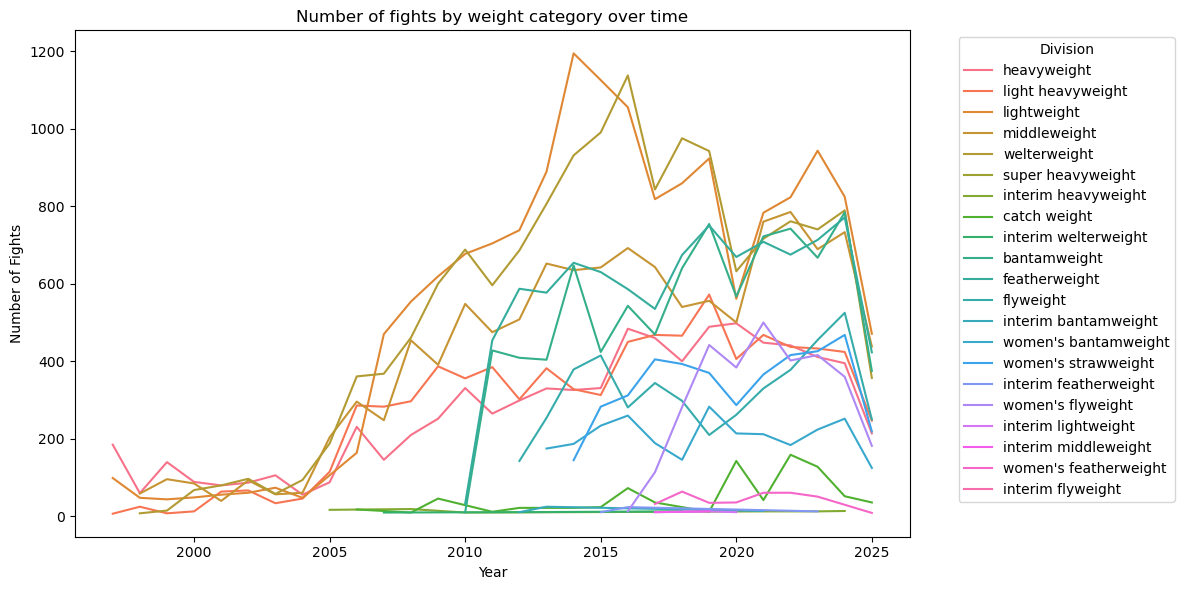

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=fights_per_year_division, x="year", y="num_fights", hue="division")
plt.title("Number of fights by weight category over time")
plt.xlabel("Year")
plt.ylabel("Number of Fights")
plt.legend(title="Division", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## General fight statistics

### Ratio of wins by knockout, submission, and decision

In [22]:
methods = filtered_raw_fight_details["method"]
methods.value_counts()

method
Decision - Unanimous       2926
KO/TKO                     2524
Submission                 1532
Decision - Split            784
Decision - Majority          95
TKO - Doctor's Stoppage      92
Overturned                   57
Could Not Continue           30
DQ                           23
Name: count, dtype: int64

In [23]:
ko_submission_decision_methods = filtered_raw_fight_details[
    filtered_raw_fight_details["method"].str.contains("KO/TKO|Submission|Decision", na=False)
]

In [24]:
ko_submission_decision_methods["method"].value_counts()

method
Decision - Unanimous    2926
KO/TKO                  2524
Submission              1532
Decision - Split         784
Decision - Majority       95
Name: count, dtype: int64

#### Groupping decision method variations

In [25]:
ko_submission_decision_methods["method_grouped"] = np.where(
    ko_submission_decision_methods["method"].str.contains("Decision", na=False),
    "Decision",
    ko_submission_decision_methods["method"]
)

/var/folders/y2/th9j6g7n1wgghjg95sgj0cqr0000gq/T/ipykernel_3905/113718741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ko_submission_decision_methods["method_grouped"] = np.where(


In [26]:
ko_submission_decision_methods["method_grouped"].value_counts()

method_grouped
Decision      3805
KO/TKO        2524
Submission    1532
Name: count, dtype: int64

### Average duration of fights by category

In [27]:
avg_duration_per_division = filtered_raw_fight_details.groupby("division")["match_time_sec"].mean().sort_values(ascending=False)

In [28]:
avg_duration_per_division

division
interim middleweight     300.000000
interim welterweight     298.000000
interim featherweight    286.500000
super heavyweight        274.000000
interim flyweight        274.000000
women's flyweight        260.342412
women's strawweight      256.167155
interim lightweight      253.666667
women's featherweight    250.724138
women's bantamweight     247.694690
flyweight                242.957672
catch weight             242.527778
bantamweight             234.779473
featherweight            234.408010
welterweight             228.450376
lightweight              227.752174
interim bantamweight     218.000000
middleweight             217.879812
light heavyweight        209.945607
heavyweight              203.719834
interim heavyweight      139.333333
Name: match_time_sec, dtype: float64

In [29]:
humanized = avg_duration_per_division.apply(lambda x: human_readable_duration(int(x)))

In [30]:
for division, duration in humanized.items():
    print(f"{division}: {duration}")

interim middleweight: 5 minutes
interim welterweight: 4 minutes
interim featherweight: 4 minutes
super heavyweight: 4 minutes
interim flyweight: 4 minutes
women's flyweight: 4 minutes
women's strawweight: 4 minutes
interim lightweight: 4 minutes
women's featherweight: 4 minutes
women's bantamweight: 4 minutes
flyweight: 4 minutes
catch weight: 4 minutes
bantamweight: 3 minutes
featherweight: 3 minutes
welterweight: 3 minutes
lightweight: 3 minutes
interim bantamweight: 3 minutes
middleweight: 3 minutes
light heavyweight: 3 minutes
heavyweight: 3 minutes
interim heavyweight: 2 minutes


### Most common submission techniques

> Although the initial objective included analyzing the most common submission techniques, the dataset used does not specify the type of submission (e.g., rear naked choke, triangle choke, kimura). Therefore, this analysis could not be performed with the available data.

### Average strikes per minute and per round

In [31]:
raw_ufc_details.head(5)

,event_id,event_name,date,location,fight_id,division,title_fight,method,finish_round,match_time_sec,...,b_splm,b_str_acc,b_sapm,b_str_def,b_td_avg,b_td_avg_acc,b_td_def,b_sub_avg,winner,winner_id
0,400c7b43c86d27d3,UFC Fight Night: Hill vs. Rountree Jr.,2025-06-21,"Baku, Azerbaijan",36ec204f47e4d613,catch weight,0,Submission,1,275,...,3.11,48,3.08,50,5.82,45,40,0.7,Myktybek Orolbai,bf2c8e01b07d3eb1
1,400c7b43c86d27d3,UFC Fight Night: Hill vs. Rountree Jr.,2025-06-21,"Baku, Azerbaijan",a1afc16e21d1a807,lightweight,0,Decision - Unanimous,3,300,...,6.55,45,4.33,56,0.00,0,75,0.4,Rafael Fiziev,c814b4c899793af6
2,400c7b43c86d27d3,UFC Fight Night: Hill vs. Rountree Jr.,2025-06-21,"Baku, Azerbaijan",7513a00037094075,lightweight,0,KO/TKO,2,257,...,4.13,38,5.28,52,0.00,0,83,0.0,Nazim Sadykhov,ff62013d2fce6d13
3,400c7b43c86d27d3,UFC Fight Night: Hill vs. Rountree Jr.,2025-06-21,"Baku, Azerbaijan",e512b80bbaea36c2,welterweight,0,Decision - Unanimous,3,300,...,3.50,48,2.24,60,1.70,44,55,0.0,Seokhyeon Ko,4a07b1988477502c
4,400c7b43c86d27d3,UFC Fight Night: Hill vs. Rountree Jr.,2025-06-21,"Baku, Azerbaijan",03bc32bdb5a33496,light heavyweight,0,Decision - Unanimous,5,300,...,3.79,40,4.24,49,0.00,0,58,0.1,Khalil Rountree Jr.,749f572d1d3161fb


#### Average strikes per minute

The main formula to calculate this is 

total strikes landed / (match_time_sec / 60)

for this metric I'll consider only complete fights, or, fights that last more than 300 sec or 5 min

In [32]:
avg_strikes_per_min_ckp = raw_ufc_details.copy()
avg_strikes_per_min_ckp = avg_strikes_per_min_ckp[
    avg_strikes_per_min_ckp["match_time_sec"] > 300
]

In [33]:
avg_strikes_per_min_ckp["avg_str_min"] = (avg_strikes_per_min_ckp["b_total_str_landed"] + avg_strikes_per_min_ckp["r_total_str_landed"]) / (avg_strikes_per_min_ckp["match_time_sec"] / 60) 

In [34]:
avg_strikes_per_min_ckp.head(5)

,event_id,event_name,date,location,fight_id,division,title_fight,method,finish_round,match_time_sec,...,b_str_acc,b_sapm,b_str_def,b_td_avg,b_td_avg_acc,b_td_def,b_sub_avg,winner,winner_id,avg_str_min
8050,a7b48e18ca27795d,UFC 20: Battle for the Gold,1999-05-07,"Birmingham, Alabama, USA",a3fe8217502c42a4,heavyweight,0,Submission,1,388,...,0,0.00,0,0.00,0,0,0.0,Pete Williams,6291ac0a3726732f,6.185567
8060,c9bbf1a0285a8076,UFC 18: The Road to the Heavyweight Title,1999-01-08,"New Orleans, Louisiana, USA",fb8e8d1a734b6fe8,middleweight,0,Submission,1,477,...,0,0.00,0,0.00,0,0,0.0,Evan Tanner,8f2d9ee27f206f1f,6.918239
8061,c9bbf1a0285a8076,UFC 18: The Road to the Heavyweight Title,1999-01-08,"New Orleans, Louisiana, USA",0cf7636471fc5e45,lightweight,0,KO/TKO,1,412,...,0,0.00,0,0.00,0,0,0.0,Laverne Clark,1c2f2571b18791b6,5.097087
8062,32a3025d5db456ae,UFC - Ultimate Brazil,1998-10-16,"Sao Paulo, Brazil",c8a04210d832a928,light heavyweight,1,Submission,1,460,...,0,0.00,0,0.00,0,0,0.0,Frank Shamrock,fcaae0385b514f11,8.608696
8064,32a3025d5db456ae,UFC - Ultimate Brazil,1998-10-16,"Sao Paulo, Brazil",f85bbc760000f001,heavyweight,0,KO/TKO,1,487,...,30,3.55,38,1.07,33,66,0.0,Pedro Rizzo,b44f39a5c6596953,9.856263


#### Average strikes per round

The main formula to calculate this is 

total strikes landed / total_rounds

for this metric I'll consider only complete fights, or, fights that last more than than 300 sec or 5 min

In [35]:
avg_strikes_per_min_ckp["avg_str_rnd"] = (avg_strikes_per_min_ckp["b_total_str_landed"] + avg_strikes_per_min_ckp["r_total_str_landed"]) /  avg_strikes_per_min_ckp["finish_round"]

In [36]:
avg_strikes_per_min_ckp.head(5)

,event_id,event_name,date,location,fight_id,division,title_fight,method,finish_round,match_time_sec,...,b_sapm,b_str_def,b_td_avg,b_td_avg_acc,b_td_def,b_sub_avg,winner,winner_id,avg_str_min,avg_str_rnd
8050,a7b48e18ca27795d,UFC 20: Battle for the Gold,1999-05-07,"Birmingham, Alabama, USA",a3fe8217502c42a4,heavyweight,0,Submission,1,388,...,0.00,0,0.00,0,0,0.0,Pete Williams,6291ac0a3726732f,6.185567,40.0
8060,c9bbf1a0285a8076,UFC 18: The Road to the Heavyweight Title,1999-01-08,"New Orleans, Louisiana, USA",fb8e8d1a734b6fe8,middleweight,0,Submission,1,477,...,0.00,0,0.00,0,0,0.0,Evan Tanner,8f2d9ee27f206f1f,6.918239,55.0
8061,c9bbf1a0285a8076,UFC 18: The Road to the Heavyweight Title,1999-01-08,"New Orleans, Louisiana, USA",0cf7636471fc5e45,lightweight,0,KO/TKO,1,412,...,0.00,0,0.00,0,0,0.0,Laverne Clark,1c2f2571b18791b6,5.097087,35.0
8062,32a3025d5db456ae,UFC - Ultimate Brazil,1998-10-16,"Sao Paulo, Brazil",c8a04210d832a928,light heavyweight,1,Submission,1,460,...,0.00,0,0.00,0,0,0.0,Frank Shamrock,fcaae0385b514f11,8.608696,66.0
8064,32a3025d5db456ae,UFC - Ultimate Brazil,1998-10-16,"Sao Paulo, Brazil",f85bbc760000f001,heavyweight,0,KO/TKO,1,487,...,3.55,38,1.07,33,66,0.0,Pedro Rizzo,b44f39a5c6596953,9.856263,80.0


## Fighter Statistics

### Top 10 fighters with the most wins

In [37]:
top_10_fighters_with_the_most_wins = raw_figther_details.sort_values(by=['wins'], ascending=False).head(10)

### Fighters with the highest KO rate

In [38]:
# filtering fights with a winner

df_winners = raw_ufc_details[raw_ufc_details["winner"].notna()].copy()

# new column to mark victories as KO/TKO
df_winners["is_ko"] = df_winners["method"].str.contains("KO", case=False, na=False)

# counting KO/TKO victories by fighter
ko_wins = df_winners[df_winners["is_ko"]].groupby("winner")["fight_id"].count().reset_index(name="ko_wins")

# counting wins by fighter
total_wins = df_winners.groupby("winner")["fight_id"].count().reset_index(name="total_wins")

# join dataframes
ko_rate_df = pd.merge(ko_wins, total_wins, on="winner")

# calculate ko rate
ko_rate_df["ko_rate"] = ko_rate_df["ko_wins"] / ko_rate_df["total_wins"]

# getting fighters with more than 10 wins

ko_rate_df = ko_rate_df[
    ko_rate_df["total_wins"] > 10
]

# ordering
ko_rate_df = ko_rate_df.sort_values(by="ko_rate", ascending=False)

ko_rate_df.head(10)

,winner,ko_wins,total_wins,ko_rate
68,Anthony Johnson,11,13,0.846154
141,Cain Velasquez,10,12,0.833333
344,Francis Ngannou,10,12,0.833333
272,Derrick Lewis,16,20,0.800000
1067,Vitor Belfort,12,15,0.800000
1012,Thiago Santos,11,14,0.785714
708,Matt Brown,13,17,0.764706
41,Alistair Overeem,9,12,0.750000
723,Mauricio Rua,8,11,0.727273
500,Joaquin Buckley,8,11,0.727273


### Performance comparasion by age

#### Calculating fighters ages

In [39]:
df = raw_ufc_details.copy()
df["r_age"] = (df["date"] - df["r_dob"]).dt.days // 365
df["b_age"] = (df["date"] - df["b_dob"]).dt.days // 365

#### Creating a new data frame with fight results and fighters age

In [40]:
red_fighters = df[["r_name", "r_age", "winner"]].rename(
    columns={"r_name": "fighter", "r_age": "age"}
)
red_fighters["is_winner"] = red_fighters["fighter"] == red_fighters["winner"]

blue_fighters = df[["b_name", "b_age", "winner"]].rename(
    columns={"b_name": "fighter", "b_age": "age"}
)
blue_fighters["is_winner"] = blue_fighters["fighter"] == blue_fighters["winner"]

fighters_df = pd.concat([red_fighters, blue_fighters])

In [41]:
fighters_df

,fighter,age,winner,is_winner
0,Tofiq Musayev,35.0,Myktybek Orolbai,False
1,Rafael Fiziev,32.0,Rafael Fiziev,True
2,Nazim Sadykhov,31.0,Nazim Sadykhov,True
3,Seokhyeon Ko,31.0,Seokhyeon Ko,True
4,Jamahal Hill,34.0,Khalil Rountree Jr.,False
...,...,...,...,...
8245,Ernie Verdicia,NaN,Oleg Taktarov,False
8246,John Dowdy,NaN,Guy Mezger,False
8247,Andy Anderson,20.0,Jon Hess,False
8248,Joe Charles,NaN,Dan Severn,False


In [42]:
performance_by_age = fighters_df.groupby("age")["is_winner"].mean().reset_index(name="win_rate")

> ⚠️ **Disclaimer: How the Win Rate by Age is Calculated**
>
> The `win_rate` (win percentage by age) in this notebook is computed by analyzing fighters' outcomes based on their age at the time of each fight.
> 
> The dataset has been transformed into a long format, where each row represents **one fighter per fight** (instead of one row per fight with two fighters). This allows us to associate each fighter with their age and match outcome individually.
>
> The win rate for each age is calculated as:
>
> **Number of fights won by fighters at a given age ÷ Total number of fights fought at that same age**
>
> For example, if fighters who were 30 years old won 60 out of 100 fights, the win rate at age 30 is 0.60.
>
> ---
>
> **Important Notes:**
> - This does **not** account for opponent strength, fight context, or event level.
> - Ages with very few fights may result in misleading rates due to low sample size.


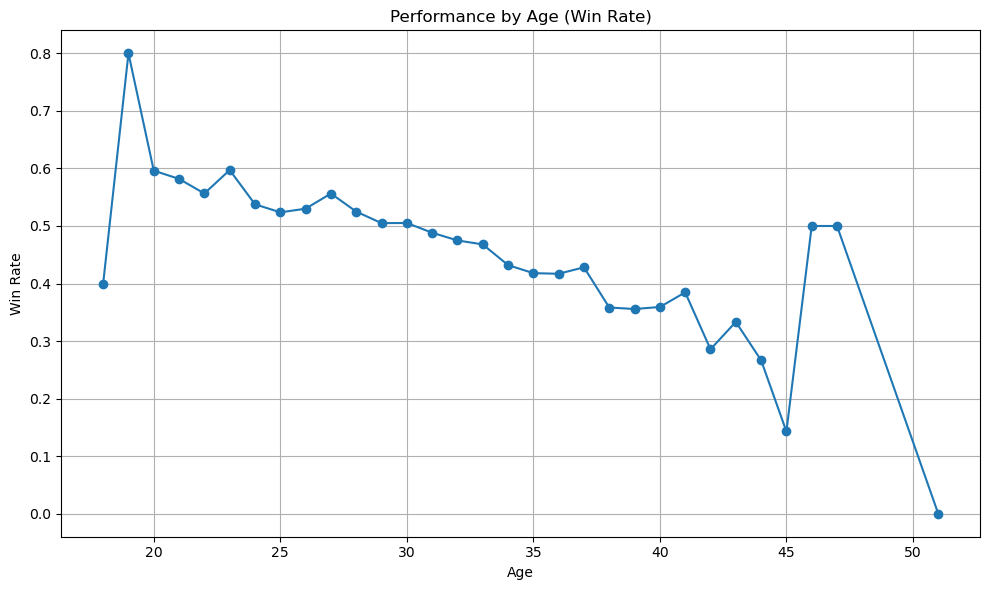

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(performance_by_age["age"], performance_by_age["win_rate"], marker="o")
plt.xlabel("Age")
plt.ylabel("Win Rate")
plt.title("Performance by Age (Win Rate)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Average career length

In [44]:
df = raw_ufc_details.copy()

In [45]:
red_fighters = df[["r_id", "r_name", "date"]].rename(columns={
    "r_id": "fighter_id",
    "r_name": "fighter_name"
})

blue_fighters = df[["b_id", "b_name", "date"]].rename(columns={
    "b_id": "fighter_id",
    "b_name": "fighter_name"
})

all_fighters = pd.concat([red_fighters, blue_fighters], ignore_index=True)

In [46]:
career_dates = all_fighters.groupby("fighter_id")["date"].agg(["min", "max"]).reset_index()
career_dates["career_length_days"] = (career_dates["max"] - career_dates["min"]).dt.days
career_dates["career_length_years"] = career_dates["career_length_days"] / 365

In [47]:
average_career_length_years = career_dates["career_length_years"].mean()
average_career_length_years

np.float64(3.204485009543695)

# 2. Analytical & Comparative Reports

> These go deeper and highlight analytical thinking, correlations, and behavior patterns.

## What Influences a Fight Outcome?

In [48]:
df_fight_outcome = raw_ufc_details.copy()

### Correlation between height/reach and win probability

In [49]:
height_diff = df_fight_outcome["r_height"] - df_fight_outcome["b_height"]
reach_diff = df_fight_outcome["r_reach"] - df_fight_outcome["b_reach"]
is_red_win = df_fight_outcome["winner"] == df_fight_outcome["r_name"]

In [50]:
df_corr = pd.DataFrame({
    "height_diff": height_diff,
    "reach_diff": reach_diff,
    "is_red_win": is_red_win.astype(int)  # True/False -> 1/0
})

#### Evaluate correlation

In [51]:
correlation_matrix = df_corr.corr()

correlation_matrix

,height_diff,reach_diff,is_red_win
height_diff,1.000000,0.621924,0.043204
reach_diff,0.621924,1.000000,0.057235
is_red_win,0.043204,0.057235,1.000000


In [52]:
corr_result = correlation_matrix["is_red_win"].sort_values(ascending=False)

In [53]:

print(
    f"Note: Based on the data, reach difference shows a correlation of "
    f"{corr_result['reach_diff']:.3f} with winning probability, "
    f"while height difference shows a correlation of {corr_result['height_diff']:.3f}. "
    "This suggests that reach has a slightly higher influence on fight outcomes than height, "
    "although both correlations are weak and should not be considered strong predictors."
)

Note: Based on the data, reach difference shows a correlation of 0.057 with winning probability, while height difference shows a correlation of 0.043. This suggests that reach has a slightly higher influence on fight outcomes than height, although both correlations are weak and should not be considered strong predictors.


### Does making weight increase win chances?

> Fighters who cut weight correctly can have a psychological and physical advantage (even if temporary) over those who miss weight, or at least, they don't suffer the penalties.

#### Divisions weight limits

#### Creating divisions dictionary

In [61]:
divisions = list(df_fight_outcome["division"].unique())

# Initialy those are weights that I know so far

# Weights in pounds

weight_limits = {
    "flyweight": 125,
    "bantamweight": 135,
    "featherweight": 145,
    "lightweight": 155,
    "welterweight": 170,
    "middleweight": 185,
    "light heavyweight": 205,
    "heavyweight": 265
}

known_divisions = list(weight_limits.keys())
for division in divisions:
    for kd in known_divisions:
        if kd in division.lower():
            weight_limits[division] = weight_limits[kd]
            break

df_fight_outcome["division_limit"] = df_fight_outcome["division"].map(weight_limits)

#### Filtering divisions with limit

In [63]:
df_fight_outcome = df_fight_outcome[df_fight_outcome["division_limit"].notna()]

#### Does the fighter made the weight?

In [74]:
# Select relevant columns for fighters in the red corner,
# renaming columns to generic fighter-related names
red_df = df_fight_outcome[[
    "fight_id", "division_limit", "r_name", "r_weight", "winner"
]].rename(columns={
    "r_name": "fighter_name",        # rename red fighter's name to "fighter_name"
    "r_weight": "fighter_weight"     # rename red fighter's weight to "fighter_weight"
})

# Create a new boolean column "won" that indicates if the red fighter won the fight
red_df["won"] = red_df["winner"] == red_df["fighter_name"]


# Repeat the same process for fighters in the blue corner:
# select relevant columns and rename them to generic fighter names
blue_df = df_fight_outcome[[
    "fight_id", "division_limit", "b_name", "b_weight", "winner"
]].rename(columns={
    "b_name": "fighter_name",        # rename blue fighter's name to "fighter_name"
    "b_weight": "fighter_weight"     # rename blue fighter's weight to "fighter_weight"
})

# Create boolean column "won" indicating if the blue fighter won
blue_df["won"] = blue_df["winner"] == blue_df["fighter_name"]


# Concatenate both dataframes (red_df and blue_df) by stacking rows,
# resulting in a dataframe with all fighters regardless of corner (red or blue)
full_df = pd.concat([red_df, blue_df], ignore_index=True)


# Create a new boolean column "made_weight" that checks if the fighter made weight,
# comparing the fighter's weight to the division weight limit
full_df["made_weight"] = full_df["fighter_weight"] <= full_df["division_limit"]


# Group the dataframe by "made_weight" (True/False),
# and calculate the mean of the "won" column for each group.
# Since "won" is boolean (True=1, False=0), the mean represents the win rate per group.
win_rate_by_weight = (
    full_df
    .groupby("made_weight")["won"]
    .mean()
    .reset_index()
)

# Print the final result: win rates grouped by whether fighters made weight or not
print(win_rate_by_weight)


   made_weight       won
0        False  0.200000
1         True  0.491056
